# TUGAS PCD 2 KELOMPOK 2

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
from PIL import Image  
from skimage.filters import rank 
from skimage.morphology import disk 
from skimage import img_as_ubyte  
import os

In [2]:
def rgb_to_grayscale(image):
    return image.convert('L')

def grayscale_to_binary(image, threshold=128):
    binary = image.point(lambda p: 255 if p > threshold else 0, '1')
    return binary

def rgb_to_binary(image, threshold=128):
    img_gray = image.convert('L')
    binary = img_gray.point(lambda p: 255 if p > threshold else 0, '1')
    return binary

def rgb_to_cmy(image):
    img_np = np.array(image) / 255.0
    cmy = 1 - img_np
    return Image.fromarray((cmy * 255).astype(np.uint8))

def rgb_to_hsi(image):
    img_np = np.array(image.convert('RGB')).astype(float) / 255.0
    r, g, b = img_np[:,:,0], img_np[:,:,1], img_np[:,:,2]
    intensity = (r + g + b) / 3
    saturation = 1 - (3 / (r + g + b + 1e-6)) * np.minimum(r, np.minimum(g, b))
    hue = np.arccos(((r - g) + (r - b)) / (2 * np.sqrt((r - g)**2 + (r - b)*(g - b)) + 1e-6))
    hue = np.degrees(hue) % 360
    hsi = np.dstack((hue, saturation, intensity))
    return Image.fromarray((hsi * 255).astype(np.uint8))

def negative_transform(image):
    img_np = np.array(image)
    neg_img = 255 - img_np
    return Image.fromarray(neg_img)

def log_transform(image, c=1):
    img_np = np.array(image).astype(float) / 255.0 
    log_img = c * np.log(1 + img_np)
    log_img = (log_img / np.max(log_img)) * 255  
    return Image.fromarray(log_img.astype(np.uint8))


def gamma_transform(img, gamma):
    img_array = np.array(img) / 255.0  
    img_gamma = np.power(img_array, gamma) 
    img_gamma = (img_gamma * 255).astype(np.uint8)  
    return Image.fromarray(img_gamma)

def calculate_histogram(image):
    hist = np.zeros(256)
    for pixel in image.getdata():
        hist[pixel] += 1
    return hist

def cumulative_histogram(hist):
    cum_hist = np.zeros(256)
    cum_hist[0] = hist[0]
    for i in range(1, 256):
        cum_hist[i] = cum_hist[i-1] + hist[i]
    return cum_hist

def calculate_histogram_rgb(image):
    img_np = np.array(image)
    
    hist_r = np.zeros(256)
    hist_g = np.zeros(256)
    hist_b = np.zeros(256)
    
    for i in range(img_np.shape[0]):
        for j in range(img_np.shape[1]):
            hist_r[img_np[i, j, 0]] += 1
            hist_g[img_np[i, j, 1]] += 1
            hist_b[img_np[i, j, 2]] += 1
            
    return hist_r, hist_g, hist_b

def cumulative_histogram_rgb(hist_r, hist_g, hist_b):
    cum_hist_r = np.zeros(256)
    cum_hist_g = np.zeros(256)
    cum_hist_b = np.zeros(256)
    
    cum_hist_r[0] = hist_r[0]
    cum_hist_g[0] = hist_g[0]
    cum_hist_b[0] = hist_b[0]
    
    for i in range(1, 256):
        cum_hist_r[i] = cum_hist_r[i-1] + hist_r[i]
        cum_hist_g[i] = cum_hist_g[i-1] + hist_g[i]
        cum_hist_b[i] = cum_hist_b[i-1] + hist_b[i]
        
    return cum_hist_r, cum_hist_g, cum_hist_b

def histogram_equalization_rgb(image):
    img_np = np.array(image)
    height, width, _ = img_np.shape
    total_pixels = height * width
    
    hist_r, hist_g, hist_b = calculate_histogram_rgb(image)
    
    cum_hist_r, cum_hist_g, cum_hist_b = cumulative_histogram_rgb(hist_r, hist_g, hist_b)
    
    norm_cum_hist_r = (cum_hist_r * 255 / total_pixels).astype(np.uint8)
    norm_cum_hist_g = (cum_hist_g * 255 / total_pixels).astype(np.uint8)
    norm_cum_hist_b = (cum_hist_b * 255 / total_pixels).astype(np.uint8)
    
    equalized_img = np.zeros_like(img_np)
    
    for i in range(height):
        for j in range(width):
            equalized_img[i, j, 0] = norm_cum_hist_r[img_np[i, j, 0]]
            equalized_img[i, j, 1] = norm_cum_hist_g[img_np[i, j, 1]]
            equalized_img[i, j, 2] = norm_cum_hist_b[img_np[i, j, 2]]
    
    return Image.fromarray(equalized_img)

def histogram_stretching_rgb(image, r_min=50, r_max=200, g_min=30, g_max=220, b_min=40, b_max=210):
    img_np = np.array(image)
    height, width, _ = img_np.shape
    
    stretched_img = np.zeros_like(img_np)
    
    if r_min == 0 and r_max == 255:
        r_min_actual = np.min(img_np[:,:,0])
        r_max_actual = np.max(img_np[:,:,0])
    else:
        r_min_actual, r_max_actual = r_min, r_max
        
    if g_min == 0 and g_max == 255:
        g_min_actual = np.min(img_np[:,:,1])
        g_max_actual = np.max(img_np[:,:,1])
    else:
        g_min_actual, g_max_actual = g_min, g_max
        
    if b_min == 0 and b_max == 255:
        b_min_actual = np.min(img_np[:,:,2])
        b_max_actual = np.max(img_np[:,:,2])
    else:
        b_min_actual, b_max_actual = b_min, b_max
    
    r_range = r_max_actual - r_min_actual
    g_range = g_max_actual - g_min_actual
    b_range = b_max_actual - b_min_actual
    
    r_range = 1 if r_range == 0 else r_range
    g_range = 1 if g_range == 0 else g_range
    b_range = 1 if b_range == 0 else b_range
    
    stretched_img[:,:,0] = np.clip((img_np[:,:,0] - r_min_actual) * (255.0 / r_range), 0, 255).astype(np.uint8)
    stretched_img[:,:,1] = np.clip((img_np[:,:,1] - g_min_actual) * (255.0 / g_range), 0, 255).astype(np.uint8)
    stretched_img[:,:,2] = np.clip((img_np[:,:,2] - b_min_actual) * (255.0 / b_range), 0, 255).astype(np.uint8)
    
    return Image.fromarray(stretched_img)

def histogram_specification(image, reference_image):
    hist_source = calculate_histogram(image)
    hist_ref = calculate_histogram(reference_image)

    cum_source = cumulative_histogram(hist_source)
    cum_ref = cumulative_histogram(hist_ref)

    mapping = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        closest_match = np.argmin(np.abs(cum_source[i] - cum_ref))
        mapping[i] = closest_match

    new_pixels = [mapping[p] for p in image.getdata()]
    output_image = Image.new('L', image.size)
    output_image.putdata(new_pixels)
    return output_image

def contrast_stretching(image, min_val=50, max_val=200):
    img_np = np.array(image, dtype=np.float32)
    img_np = np.clip(img_np, min_val, max_val)  
    stretched = 255 * (img_np - min_val) / (max_val - min_val)  
    return Image.fromarray(stretched.astype(np.uint8))

def intensity_level_slicing(image, min_val=100, max_val=200, preserve_intensity=True):
    img_np = np.array(image.convert('L'))  
    if preserve_intensity:
        sliced_img = np.where((img_np >= min_val) & (img_np <= max_val), img_np, 0)
    else:
        sliced_img = np.where((img_np >= min_val) & (img_np <= max_val), 255, 0)
    
    return Image.fromarray(sliced_img.astype(np.uint8))

def bit_plane_slicing(image, bit):
    img_np = np.array(image)
    bit_plane = (img_np & (1 << bit)) >> bit
    return Image.fromarray((bit_plane * 255).astype(np.uint8))

def local_histogram_processing(image, kernel_size=3):
    img_np = np.array(image)
    local_hist = rank.equalize(img_np, footprint=disk(kernel_size))
    return Image.fromarray(img_as_ubyte(local_hist))

def plot_histogram(image, title="Histogram"):
    if image.mode == '1':  
        img_array = np.array(image.convert('L')).flatten()
    elif image.mode == 'RGB':
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        colors = ['red', 'green', 'blue']
        
        for i, color in enumerate(colors):
            img_array = np.array(image)[:,:,i].flatten()
            ax[i].hist(img_array, bins=256, color=color, alpha=0.7)
            ax[i].set_title(f'{color.capitalize()} Channel')
            ax[i].set_xlim([0, 255])
        
        fig.suptitle(title)
        plt.tight_layout()
        return fig
    else:
        img_array = np.array(image).flatten()
    
    if image.mode != 'RGB':
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.hist(img_array, bins=256, color='gray', alpha=0.7)
        ax.set_title(title)
        ax.set_xlim([0, 255])
        plt.tight_layout()
        return fig

def plot_histogram_comparison(original, processed, title_orig="Original", title_proc="Processed"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    if original.mode == '1':  
        img_array_orig = np.array(original.convert('L')).flatten()
    else:
        if original.mode != 'L':
            original = original.convert('L')
        img_array_orig = np.array(original).flatten()
    
    if processed.mode == '1':  
        img_array_proc = np.array(processed.convert('L')).flatten()
    else:
        if processed.mode != 'L':
            processed = processed.convert('L')
        img_array_proc = np.array(processed).flatten()
    
    ax1.hist(img_array_orig, bins=256, color='blue', alpha=0.7)
    ax1.set_title(title_orig)
    ax1.set_xlim([0, 255])
    
    ax2.hist(img_array_proc, bins=256, color='red', alpha=0.7)
    ax2.set_title(title_proc)
    ax2.set_xlim([0, 255])
    
    plt.tight_layout()
    return fig

def plot_rgb_histograms_comparison(original, processed, title_orig="Original", title_proc="Processed"):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    orig_np = np.array(original)
    axes[0, 0].hist(orig_np[:,:,0].flatten(), bins=256, color='red', alpha=0.7)
    axes[0, 0].set_title(f"{title_orig} - Red Channel")
    axes[0, 0].set_xlim([0, 255])
    
    axes[0, 1].hist(orig_np[:,:,1].flatten(), bins=256, color='green', alpha=0.7)
    axes[0, 1].set_title(f"{title_orig} - Green Channel")
    axes[0, 1].set_xlim([0, 255])
    
    axes[0, 2].hist(orig_np[:,:,2].flatten(), bins=256, color='blue', alpha=0.7)
    axes[0, 2].set_title(f"{title_orig} - Blue Channel")
    axes[0, 2].set_xlim([0, 255])
    
    proc_np = np.array(processed)
    axes[1, 0].hist(proc_np[:,:,0].flatten(), bins=256, color='red', alpha=0.7)
    axes[1, 0].set_title(f"{title_proc} - Red Channel")
    axes[1, 0].set_xlim([0, 255])
    
    axes[1, 1].hist(proc_np[:,:,1].flatten(), bins=256, color='green', alpha=0.7)
    axes[1, 1].set_title(f"{title_proc} - Green Channel")
    axes[1, 1].set_xlim([0, 255])
    
    axes[1, 2].hist(proc_np[:,:,2].flatten(), bins=256, color='blue', alpha=0.7)
    axes[1, 2].set_title(f"{title_proc} - Blue Channel")
    axes[1, 2].set_xlim([0, 255])
    
    plt.tight_layout()
    return fig


In [3]:
def display(image_path, operation=None):
    output_dir = "output/output2_ipynb"
    os.makedirs(output_dir, exist_ok=True)
    
    img = Image.open(image_path)
    img_gray = rgb_to_grayscale(img)

    processed_img = None
    title = "Original vs Processed Image"
    
    if operation == "RGB to Binary":
        processed_img = rgb_to_binary(img, threshold=128)
        title = "Original vs Binary Image"
    elif operation == "RGB to CMY":
        processed_img = rgb_to_cmy(img)
        title = "Original vs CMY Image"
    elif operation == "RGB to HSI":
        processed_img = rgb_to_hsi(img)
        title = "Original vs HSI Image"
    elif operation == "Negative Transformation":
        processed_img = negative_transform(img)
        title = "Original vs Negative Image"
    elif operation == "Log Transformation":
        processed_img = log_transform(img, c=1)
        title = "Original vs Log Transformed Image"
    elif operation == "Gamma Transformation":
        processed_img = gamma_transform(img, gamma=2.57)
        title = "Original vs Gamma Corrected Image"
    elif operation == "Histogram Equalization":
        processed_img = histogram_equalization_rgb(img)
        title = "Original vs Histogram Equalized Image"
    elif operation == "Histogram Stretching":
        processed_img = histogram_stretching_rgb(img)
        title = "Original vs Histogram Stretched Image"
    elif operation == "Bit-plane Slicing":
        processed_img = bit_plane_slicing(img_gray, bit=7)
        title = "Original vs Bit-plane Sliced Image"
    elif operation == "Contrast Stretching":
        processed_img = contrast_stretching(img_gray, min_val=50, max_val=200)
        title = "Original vs Contrast Stretched Image"
    elif operation == "Intensity Level Slicing":
        processed_img = intensity_level_slicing(img, min_val=100, max_val=200)
        title = "Original vs Intensity Level Sliced Image"
    elif operation == "Local Histogram Processing":
        processed_img = local_histogram_processing(img_gray, kernel_size=3)
        title = "Original vs Local Histogram Processed Image"
    
    is_rgb_orig = img.mode == 'RGB'
    is_rgb_processed = processed_img is not None and processed_img.mode == 'RGB'
    
    if is_rgb_orig and is_rgb_processed:
        fig = plt.figure(figsize=(15, 15))
        gs = fig.add_gridspec(4, 3)
    elif is_rgb_orig or is_rgb_processed:
        fig = plt.figure(figsize=(15, 12))
        gs = fig.add_gridspec(3, 3)
    else:
        fig = plt.figure(figsize=(15, 10))
        gs = fig.add_gridspec(2, 2)
    
    ax_orig = fig.add_subplot(gs[0, 0])
    ax_orig.imshow(img)
    ax_orig.set_title("Original Image")
    ax_orig.axis('off')
    
    if processed_img is not None:
        ax_proc = fig.add_subplot(gs[0, 1])
        if processed_img.mode == '1':  
            ax_proc.imshow(processed_img, cmap='binary')
        elif processed_img.mode == 'L' or operation in ["Contrast Stretching", "Bit-plane Slicing", 
                                                    "Intensity Level Slicing", "Local Histogram Processing"]:
            ax_proc.imshow(processed_img, cmap='gray')
        else:
            ax_proc.imshow(processed_img)
        ax_proc.set_title(f"Processed: {operation}")
        ax_proc.axis('off')
    
    orig_np = np.array(img)
    
    if is_rgb_orig:
        ax_orig_r = fig.add_subplot(gs[1, 0])
        ax_orig_r.hist(orig_np[:,:,0].flatten(), bins=256, color='red', alpha=0.7)
        ax_orig_r.set_title("Original - Red Channel")
        ax_orig_r.set_xlim([0, 255])
        
        ax_orig_g = fig.add_subplot(gs[1, 1])
        ax_orig_g.hist(orig_np[:,:,1].flatten(), bins=256, color='green', alpha=0.7)
        ax_orig_g.set_title("Original - Green Channel")
        ax_orig_g.set_xlim([0, 255])
        
        ax_orig_b = fig.add_subplot(gs[1, 2])
        ax_orig_b.hist(orig_np[:,:,2].flatten(), bins=256, color='blue', alpha=0.7)
        ax_orig_b.set_title("Original - Blue Channel")
        ax_orig_b.set_xlim([0, 255])
    else:
        ax_orig_gray = fig.add_subplot(gs[1, 0:2])
        orig_gray_np = np.array(img_gray if img.mode == 'RGB' else img).flatten()
        ax_orig_gray.hist(orig_gray_np, bins=256, color='gray', alpha=0.7)
        ax_orig_gray.set_title("Original - Grayscale")
        ax_orig_gray.set_xlim([0, 255])
    
    if processed_img is not None:
        if processed_img.mode == '1':  
            proc_np = np.array(processed_img.convert('L'))
            ax_proc_gray = fig.add_subplot(gs[2, 0:2] if is_rgb_orig else gs[1, 2])
            ax_proc_gray.hist(proc_np.flatten(), bins=2, color='black', alpha=0.7)
            ax_proc_gray.set_title("Processed - Binary")
            ax_proc_gray.set_xlim([0, 255])
        elif is_rgb_processed:
            proc_np = np.array(processed_img)
            row_idx = 2 if is_rgb_orig else 1
            
            ax_proc_r = fig.add_subplot(gs[row_idx, 0])
            ax_proc_r.hist(proc_np[:,:,0].flatten(), bins=256, color='red', alpha=0.7)
            ax_proc_r.set_title("Processed - Red Channel")
            ax_proc_r.set_xlim([0, 255])
            
            ax_proc_g = fig.add_subplot(gs[row_idx, 1])
            ax_proc_g.hist(proc_np[:,:,1].flatten(), bins=256, color='green', alpha=0.7)
            ax_proc_g.set_title("Processed - Green Channel")
            ax_proc_g.set_xlim([0, 255])
            
            ax_proc_b = fig.add_subplot(gs[row_idx, 2])
            ax_proc_b.hist(proc_np[:,:,2].flatten(), bins=256, color='blue', alpha=0.7)
            ax_proc_b.set_title("Processed - Blue Channel")
            ax_proc_b.set_xlim([0, 255])
            
            if is_rgb_orig and is_rgb_processed:
                ax_comp_r = fig.add_subplot(gs[3, 0])
                ax_comp_r.hist(orig_np[:,:,0].flatten(), bins=256, color='red', alpha=0.5, label='Original')
                ax_comp_r.hist(proc_np[:,:,0].flatten(), bins=256, color='darkred', alpha=0.5, label='Processed')
                ax_comp_r.set_title("Red Channel Comparison")
                ax_comp_r.set_xlim([0, 255])
                ax_comp_r.legend()
                
                ax_comp_g = fig.add_subplot(gs[3, 1])
                ax_comp_g.hist(orig_np[:,:,1].flatten(), bins=256, color='green', alpha=0.5, label='Original')
                ax_comp_g.hist(proc_np[:,:,1].flatten(), bins=256, color='darkgreen', alpha=0.5, label='Processed')
                ax_comp_g.set_title("Green Channel Comparison")
                ax_comp_g.set_xlim([0, 255])
                ax_comp_g.legend()
                
                ax_comp_b = fig.add_subplot(gs[3, 2])
                ax_comp_b.hist(orig_np[:,:,2].flatten(), bins=256, color='blue', alpha=0.5, label='Original')
                ax_comp_b.hist(proc_np[:,:,2].flatten(), bins=256, color='darkblue', alpha=0.5, label='Processed')
                ax_comp_b.set_title("Blue Channel Comparison")
                ax_comp_b.set_xlim([0, 255])
                ax_comp_b.legend()
        else:
            proc_np = np.array(processed_img.convert('L') if processed_img.mode not in ['L', '1'] else processed_img)
            row_idx = 2 if is_rgb_orig else 1
            ax_proc_gray = fig.add_subplot(gs[row_idx, 2] if is_rgb_orig else gs[1, 2])
            ax_proc_gray.hist(proc_np.flatten(), bins=256, color='blue', alpha=0.7)
            ax_proc_gray.set_title("Processed - Grayscale")
            ax_proc_gray.set_xlim([0, 255])
            
            if not is_rgb_orig:
                ax_comp = fig.add_subplot(gs[1, 0:2])
                orig_gray_np = np.array(img_gray if img.mode == 'RGB' else img).flatten()
                ax_comp.hist(orig_gray_np, bins=256, color='gray', alpha=0.5, label='Original')
                ax_comp.hist(proc_np.flatten(), bins=256, color='blue', alpha=0.5, label='Processed')
                ax_comp.set_title("Grayscale Comparison")
                ax_comp.set_xlim([0, 255])
                ax_comp.legend()
    
    plt.tight_layout()

    if operation is not None:
        safe_filename = operation.replace(" ", "_").replace("/", "_to_")
        output_path = os.path.join(output_dir, f"{safe_filename}.png")
        fig.savefig(output_path, bbox_inches='tight', dpi=300)
        print(f"Saved figure to {output_path}")
    
    plt.show()

In [4]:
image_path = "image/IMG-20180108-WA0115.jpg"

Saved figure to output/output2_ipynb/RGB_to_Binary.png


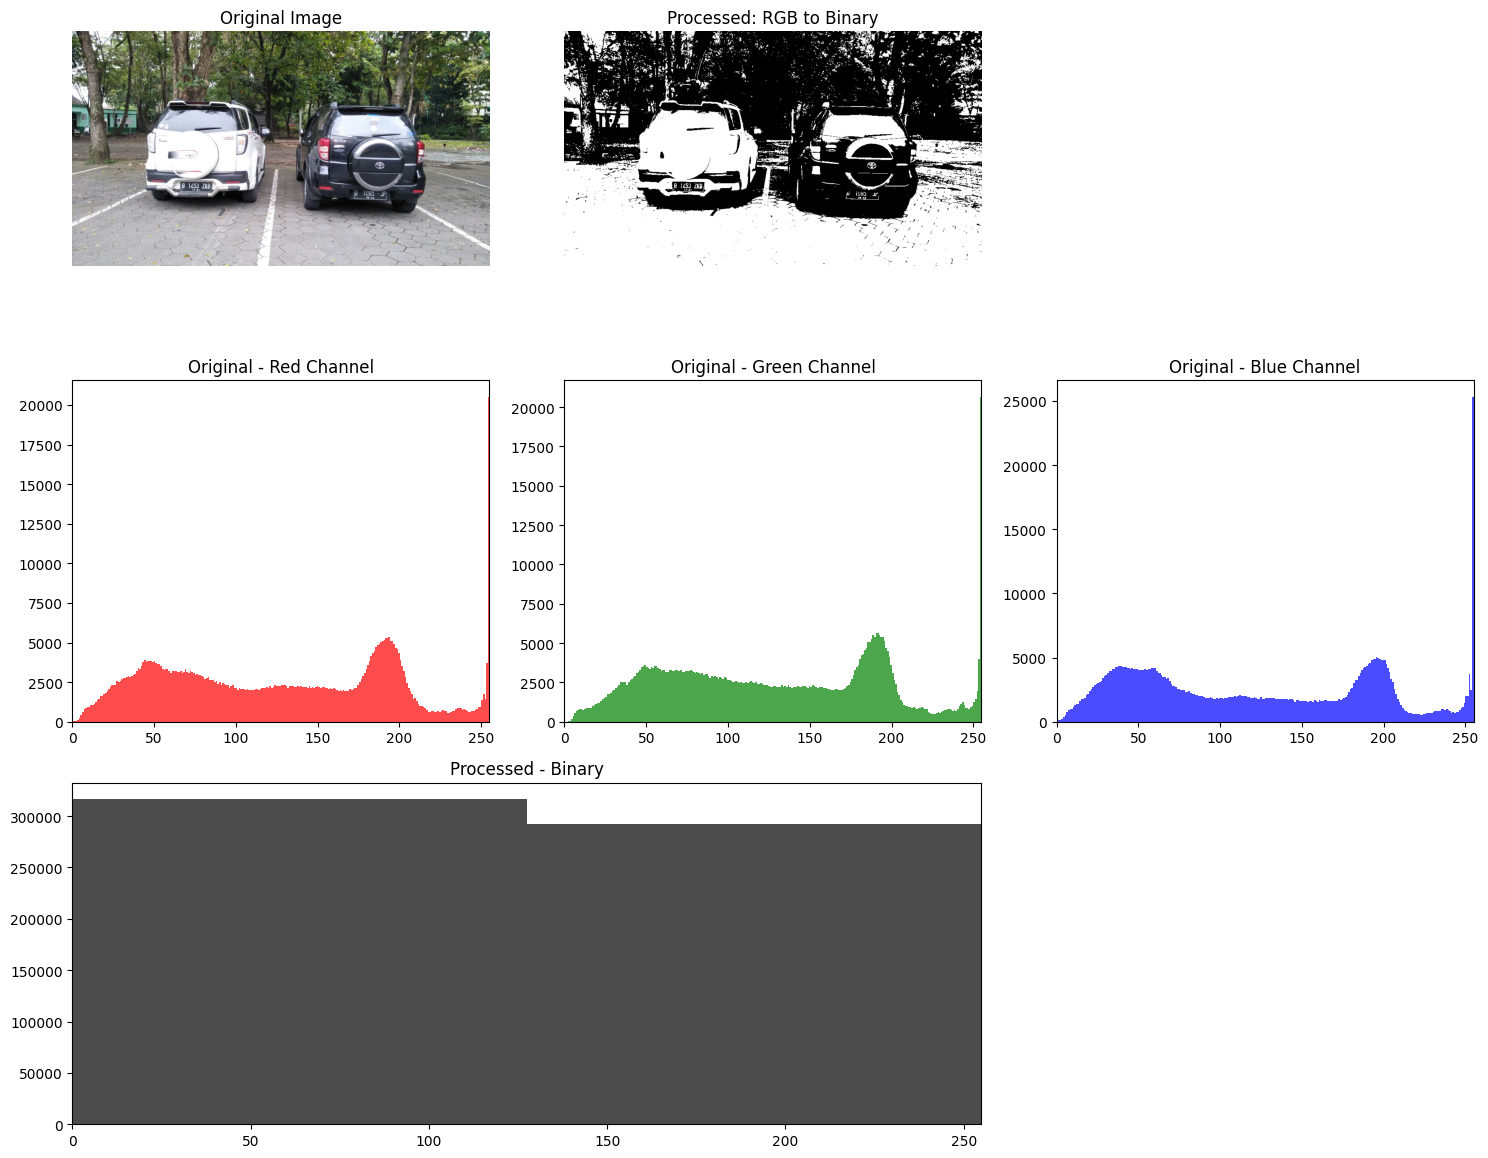

In [5]:
display(image_path, "RGB to Binary")

Saved figure to output/output2_ipynb/RGB_to_CMY.png


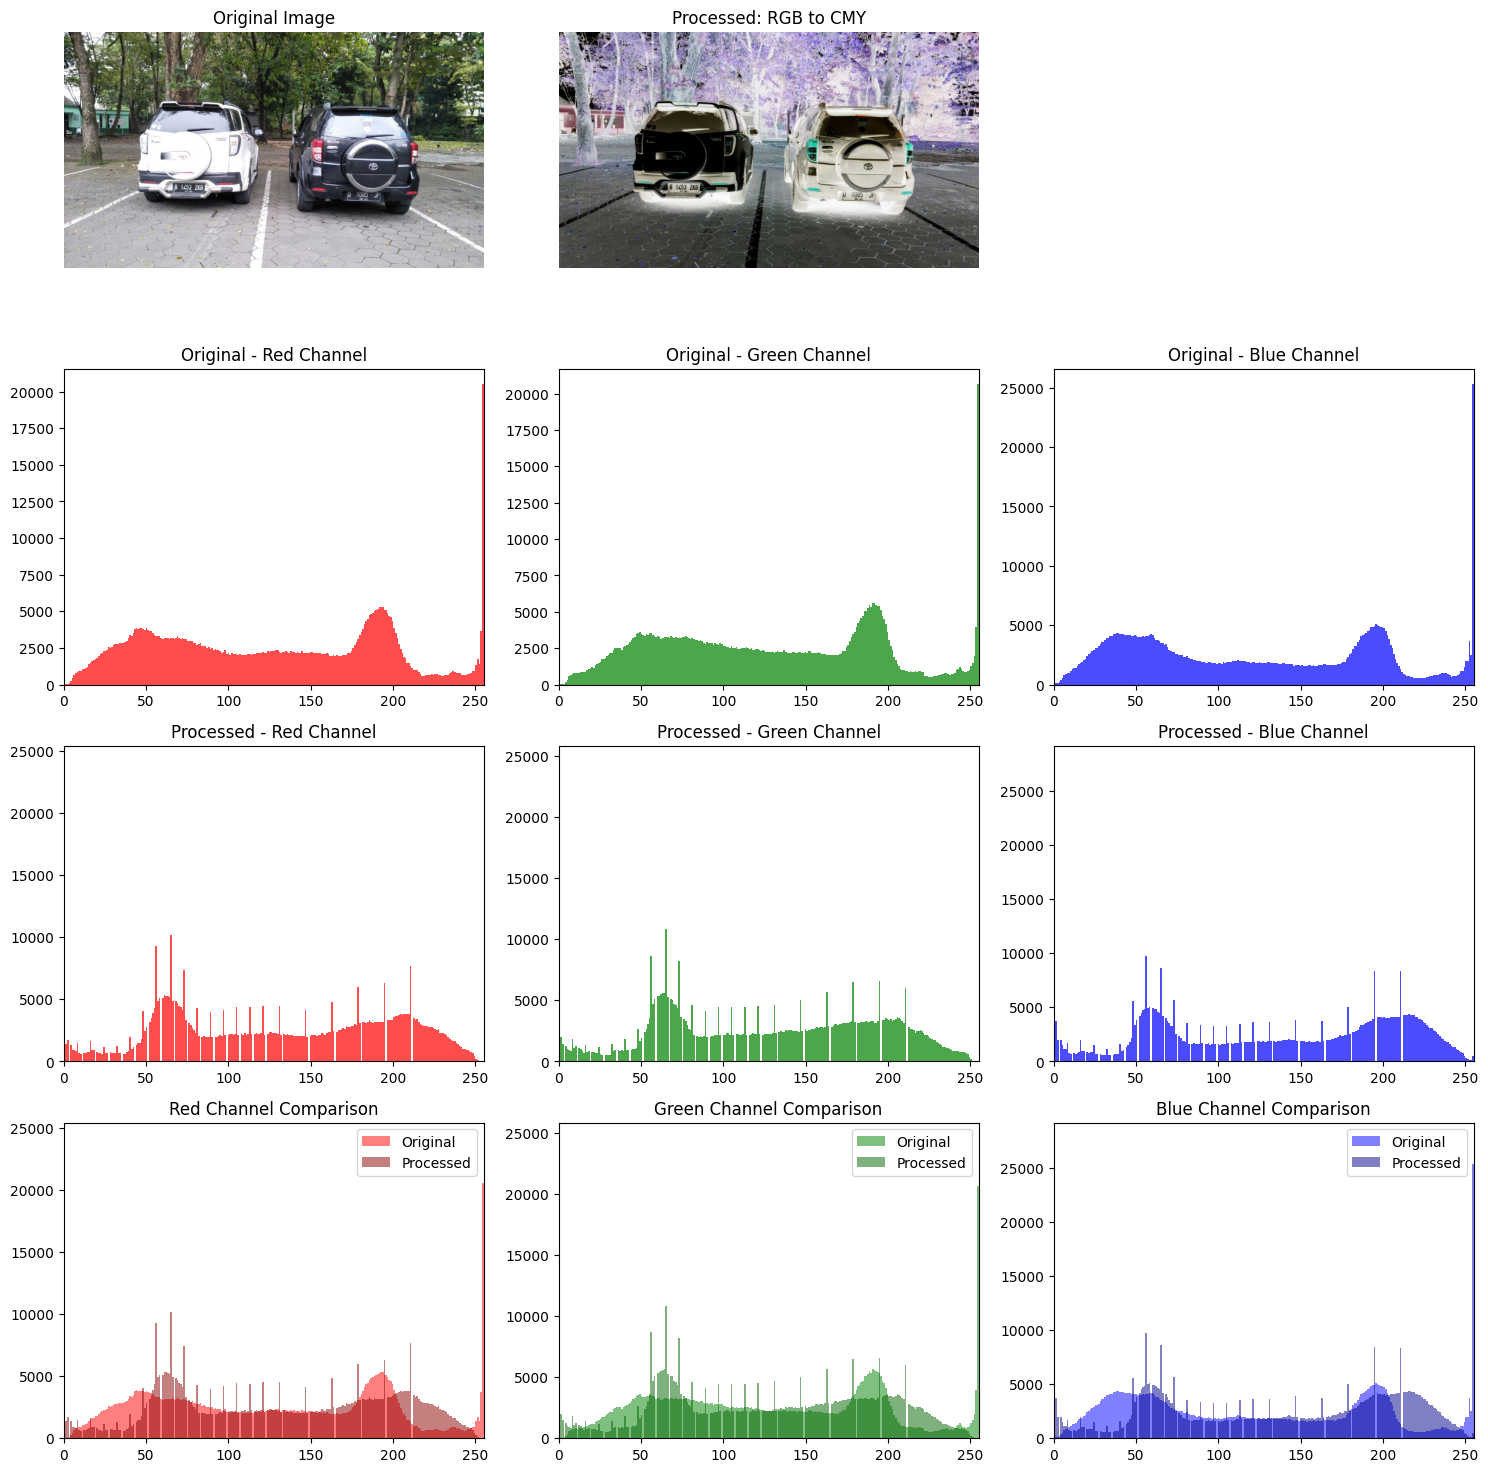

In [6]:
display(image_path, "RGB to CMY")

Saved figure to output/output2_ipynb/RGB_to_HSI.png


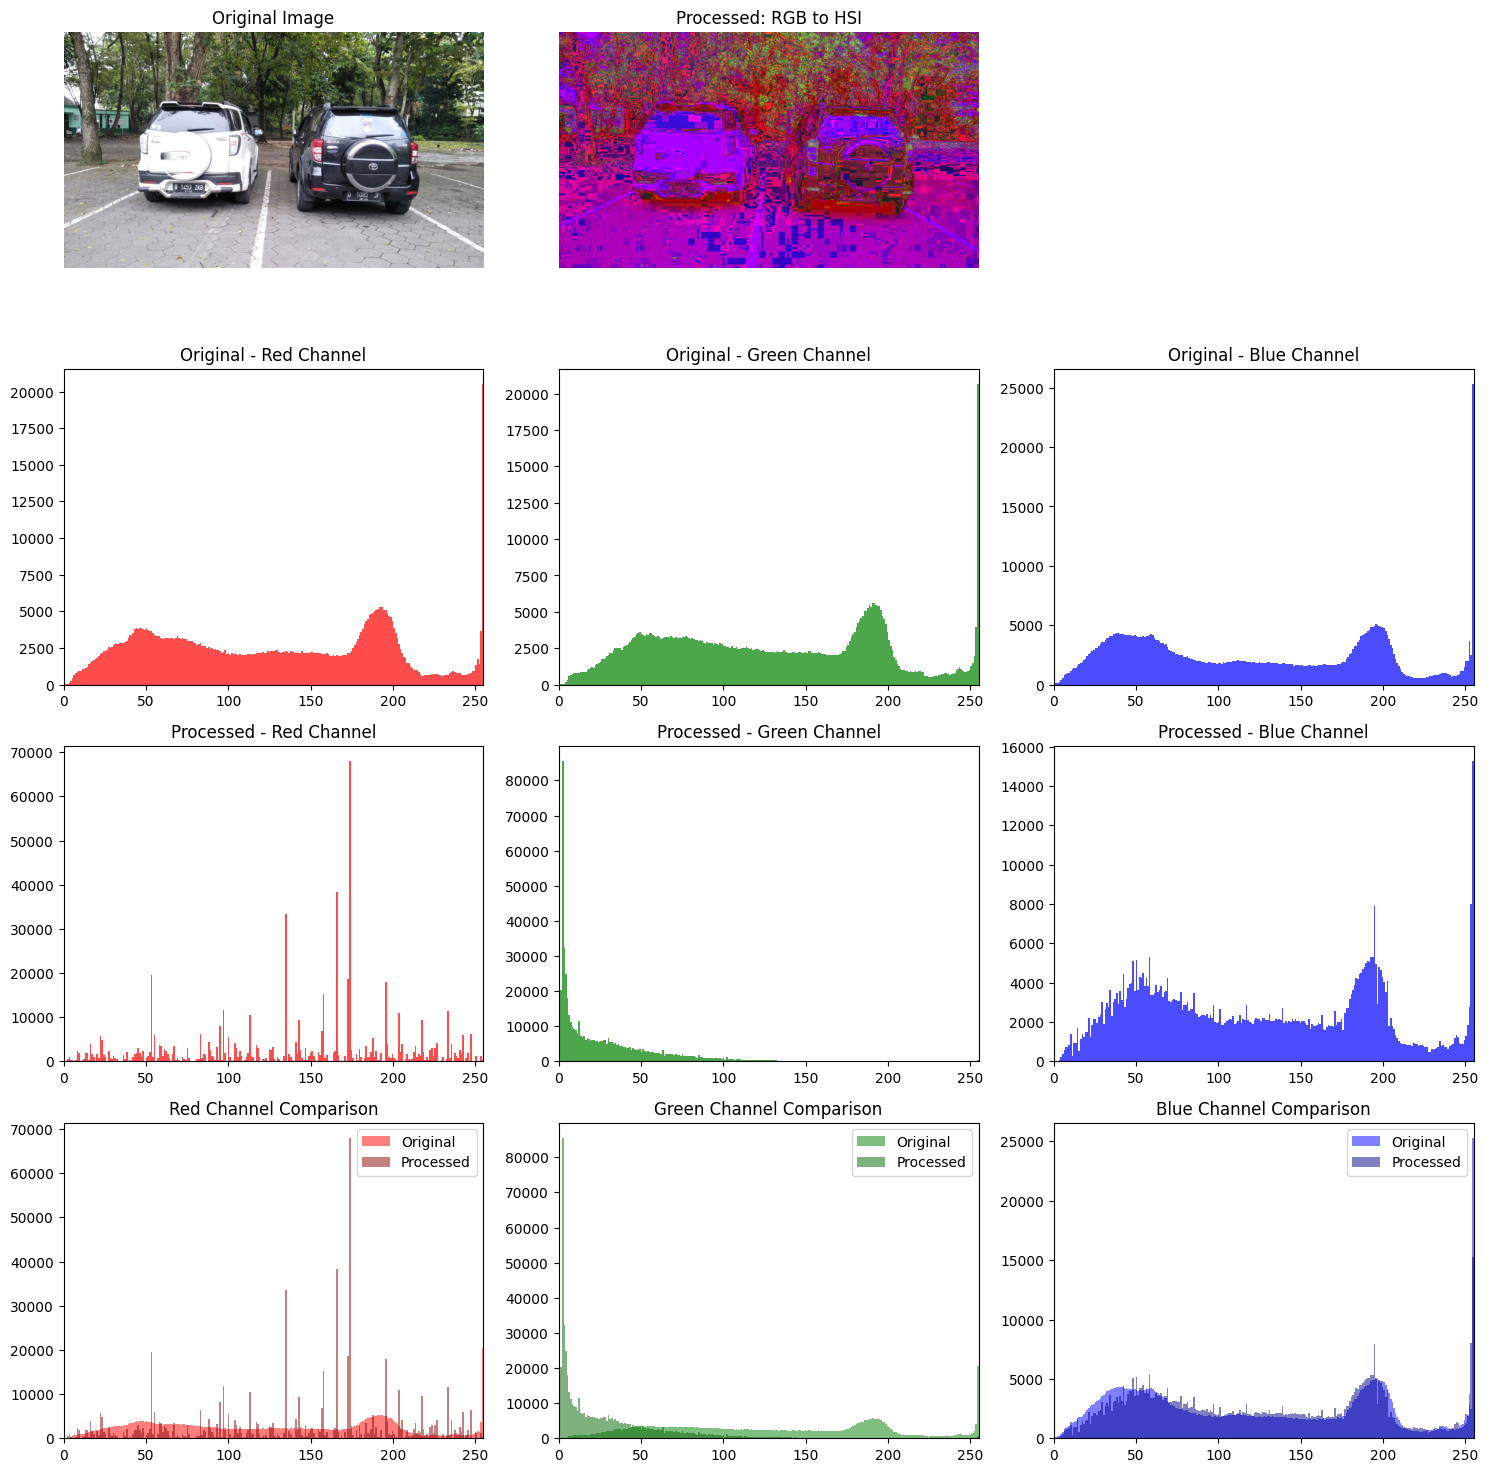

In [7]:
display(image_path, "RGB to HSI")

Saved figure to output/output2_ipynb/Negative_Transformation.png


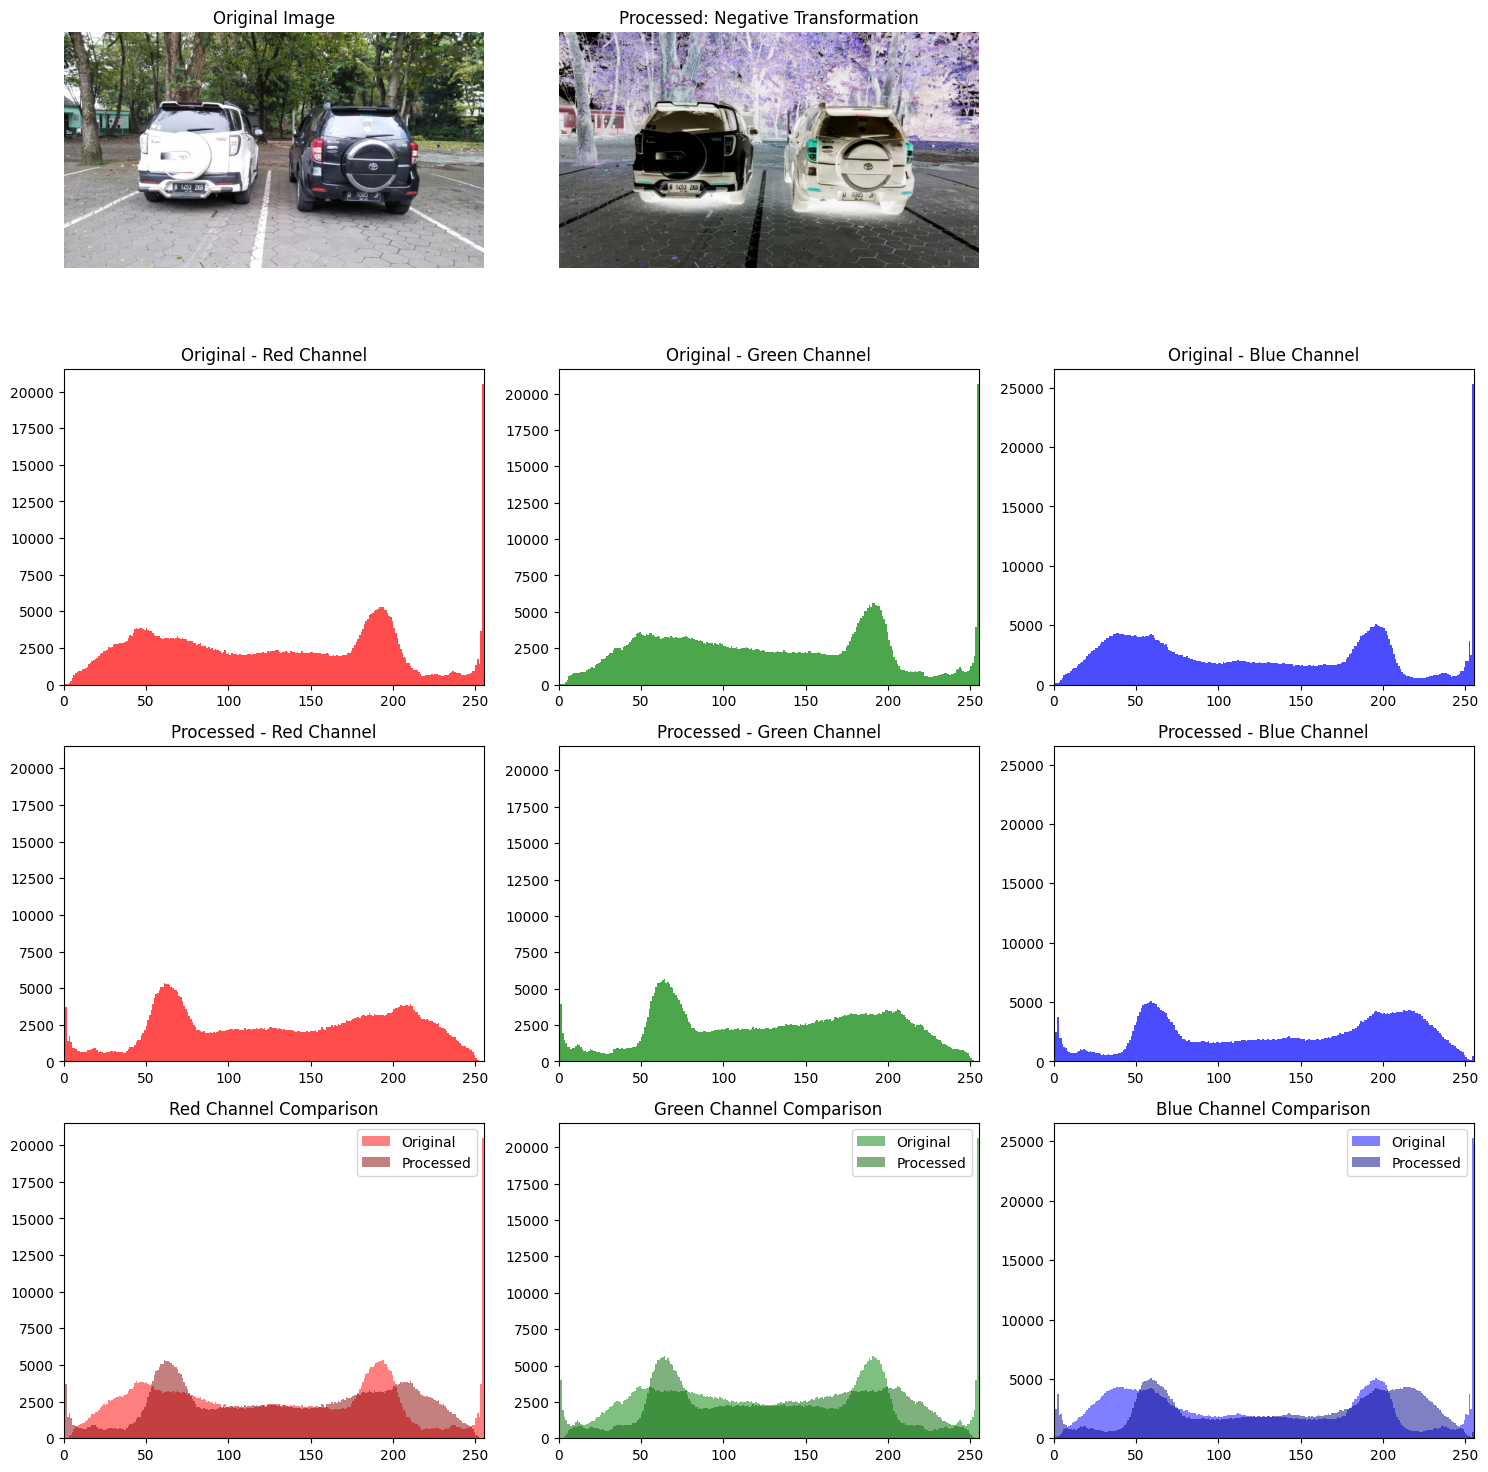

In [8]:
display(image_path, "Negative Transformation")

Saved figure to output/output2_ipynb/Log_Transformation.png


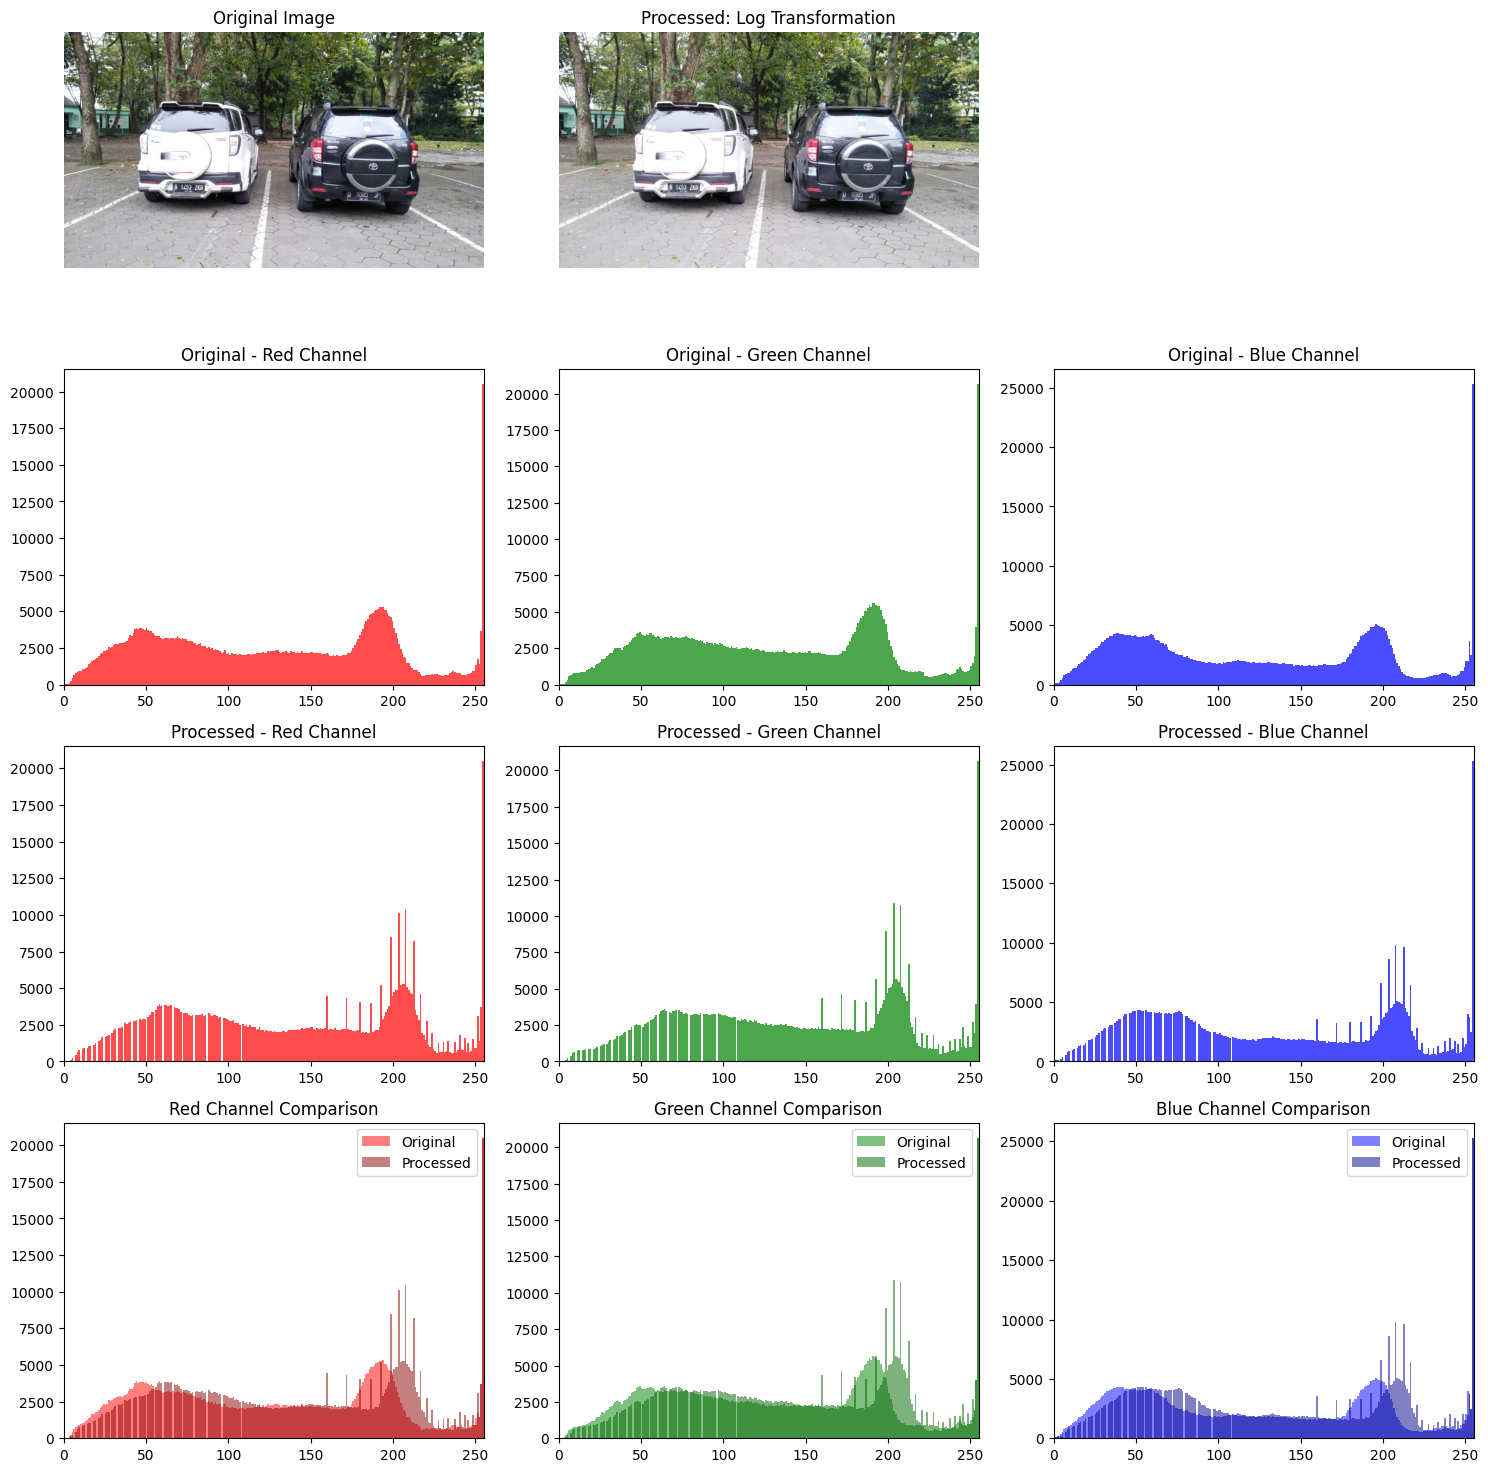

In [9]:
display(image_path, "Log Transformation")

Saved figure to output/output2_ipynb/Gamma_Transformation.png


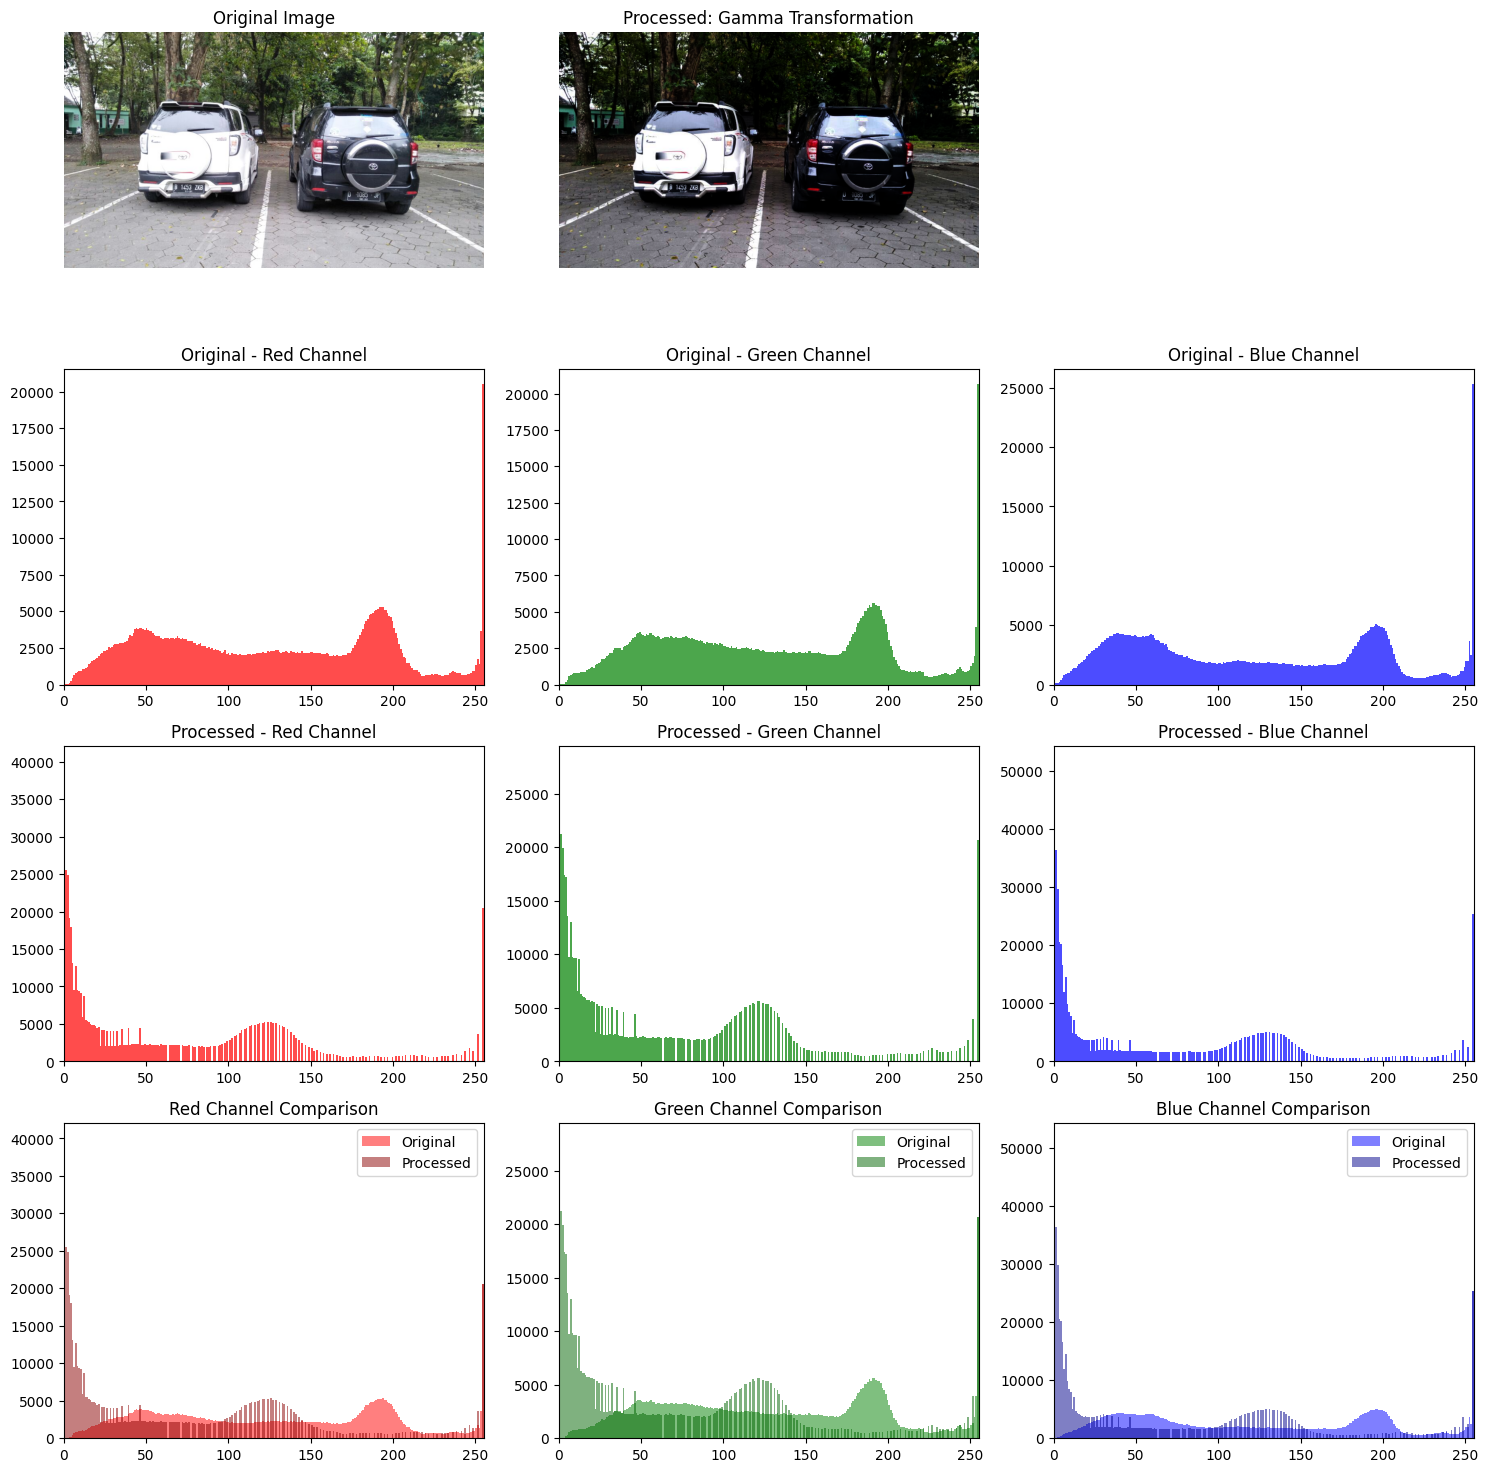

In [10]:
display(image_path, "Gamma Transformation")

Saved figure to output/output2_ipynb/Bit-plane_Slicing.png


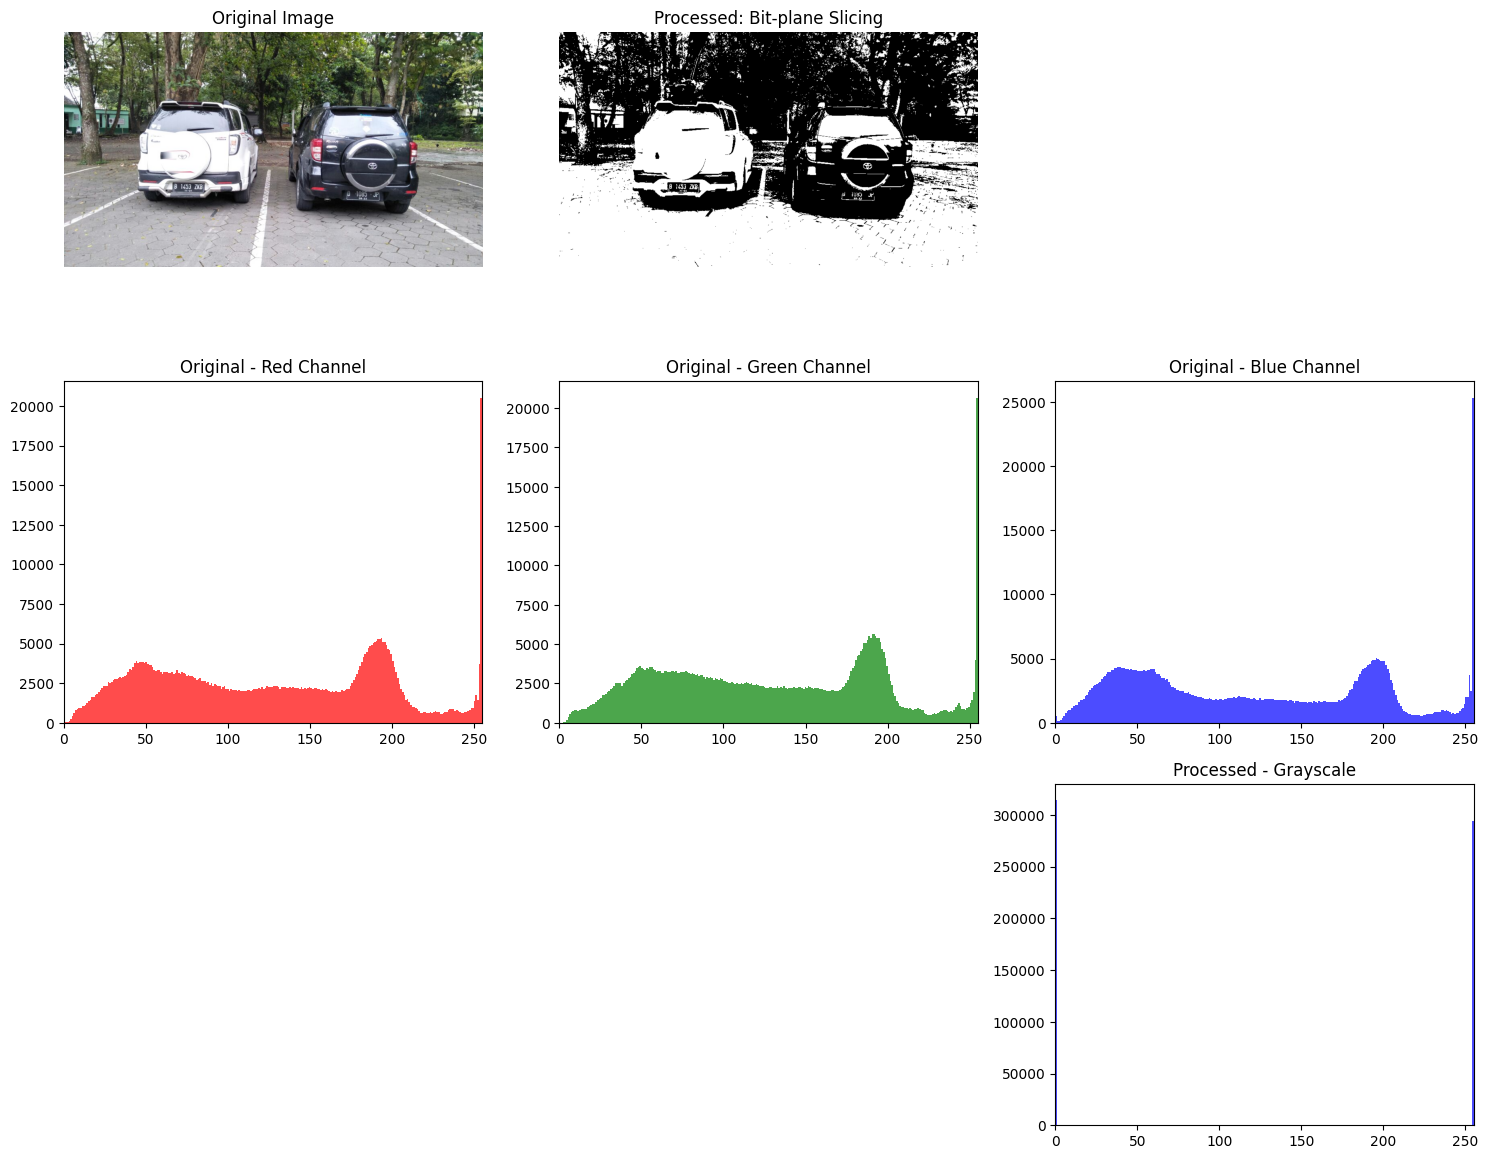

In [11]:
display(image_path, "Bit-plane Slicing")

Saved figure to output/output2_ipynb/Contrast_Stretching.png


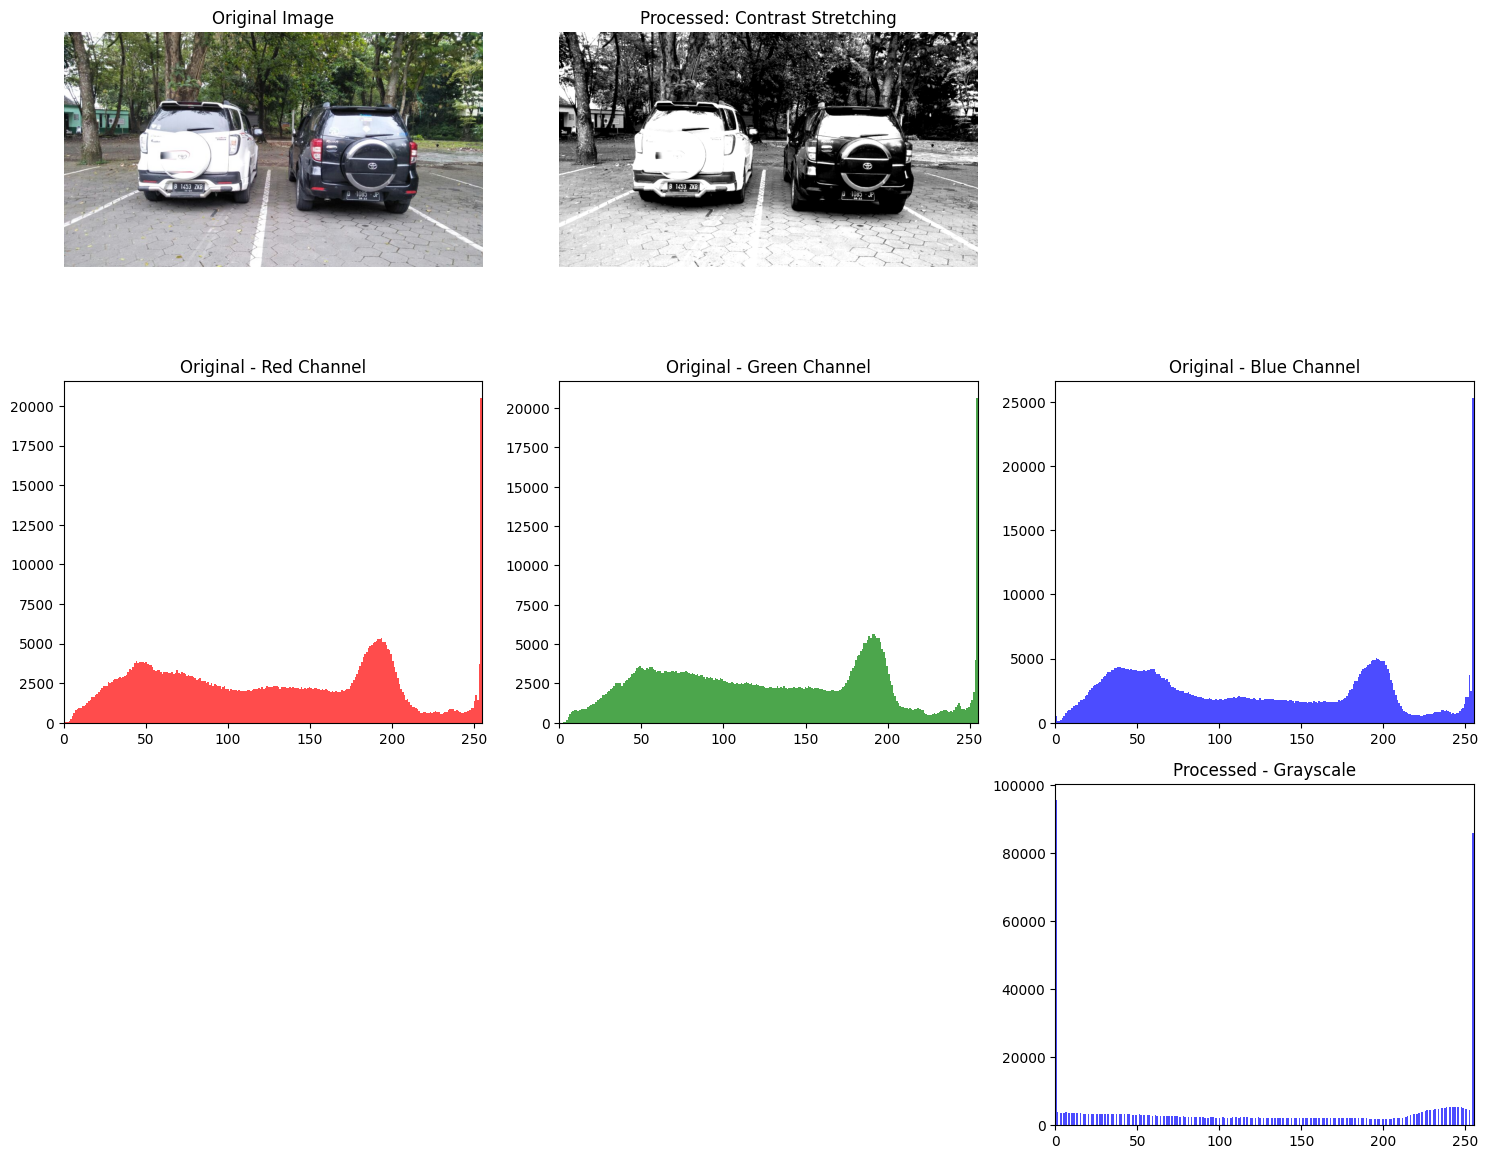

In [12]:
display(image_path, "Contrast Stretching")

Saved figure to output/output2_ipynb/Intensity_Level_Slicing.png


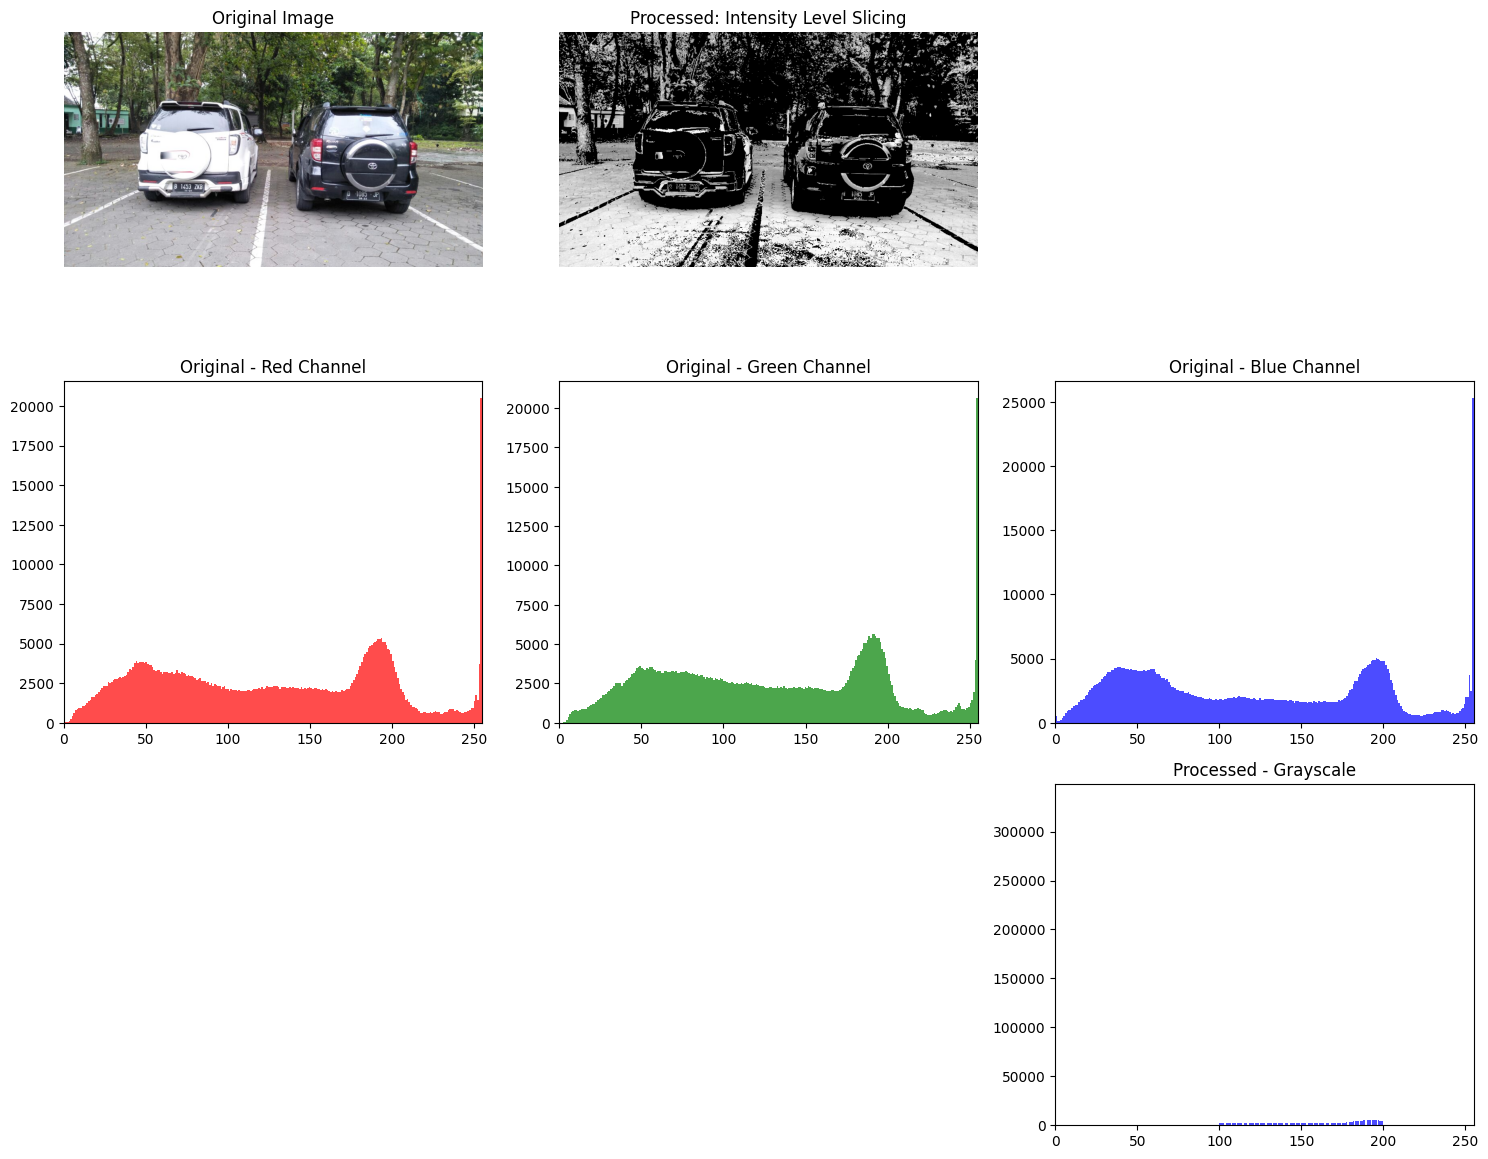

In [13]:
display(image_path, "Intensity Level Slicing")

Saved figure to output/output2_ipynb/Local_Histogram_Processing.png


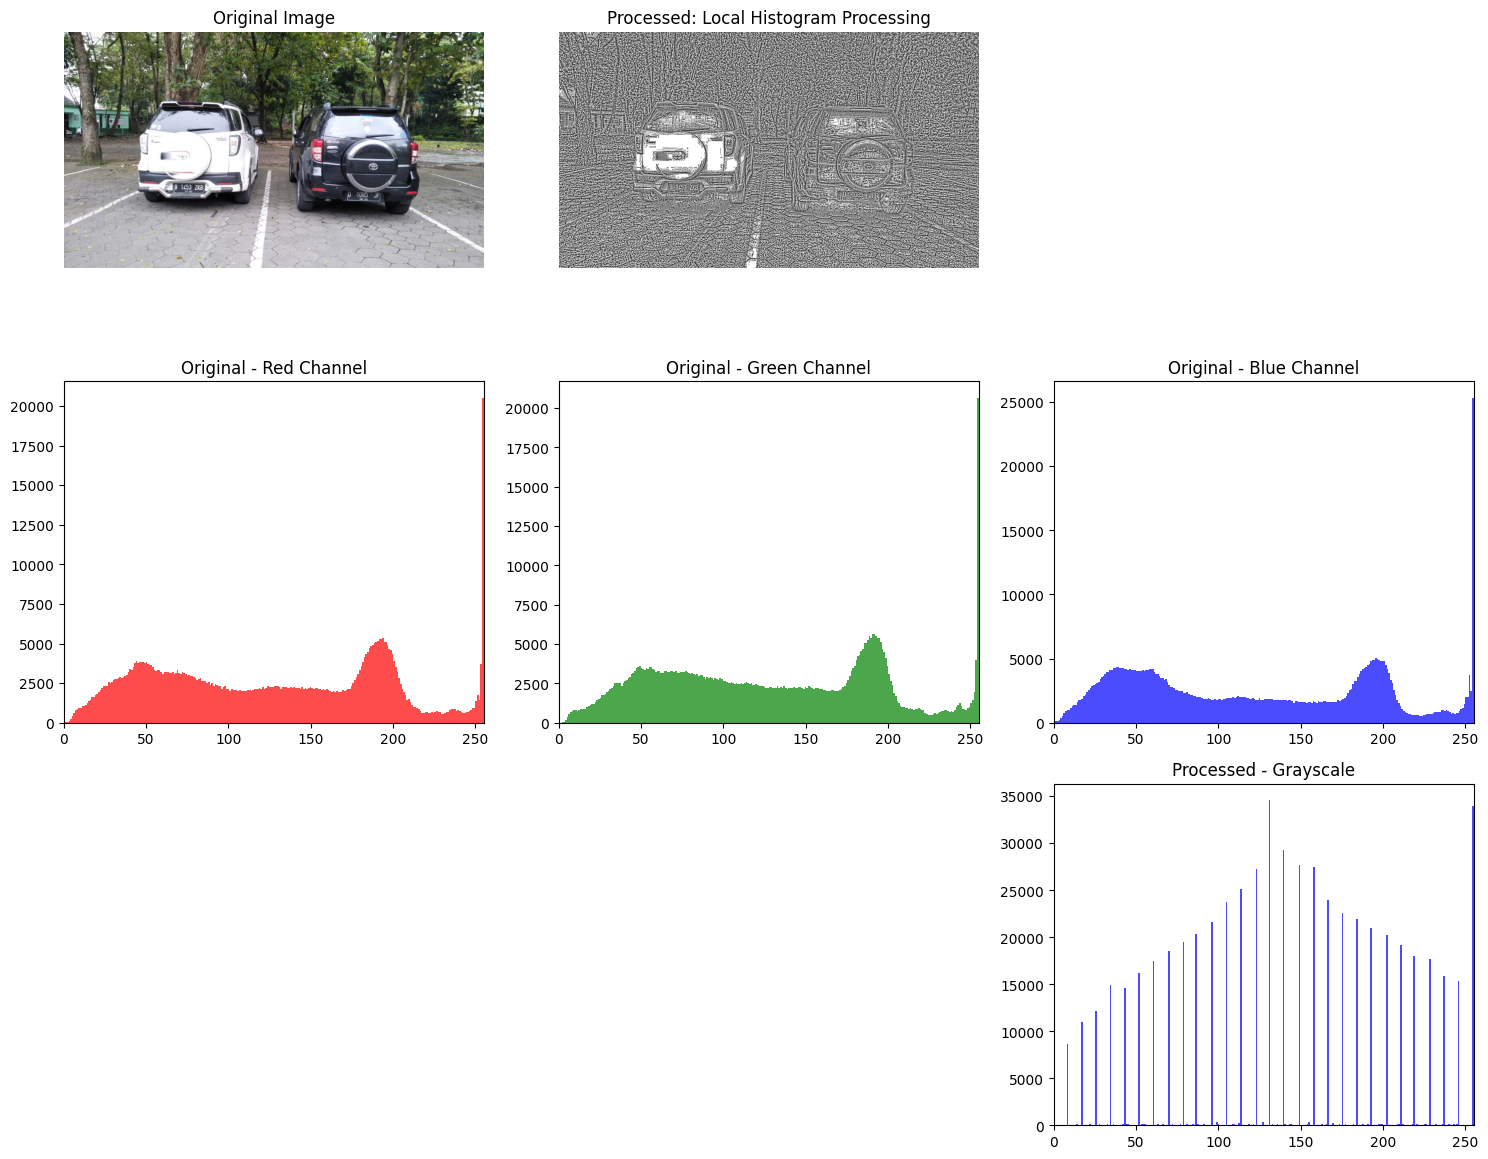

In [14]:
display(image_path, "Local Histogram Processing")

Saved figure to output/output2_ipynb/Histogram_Equalization.png


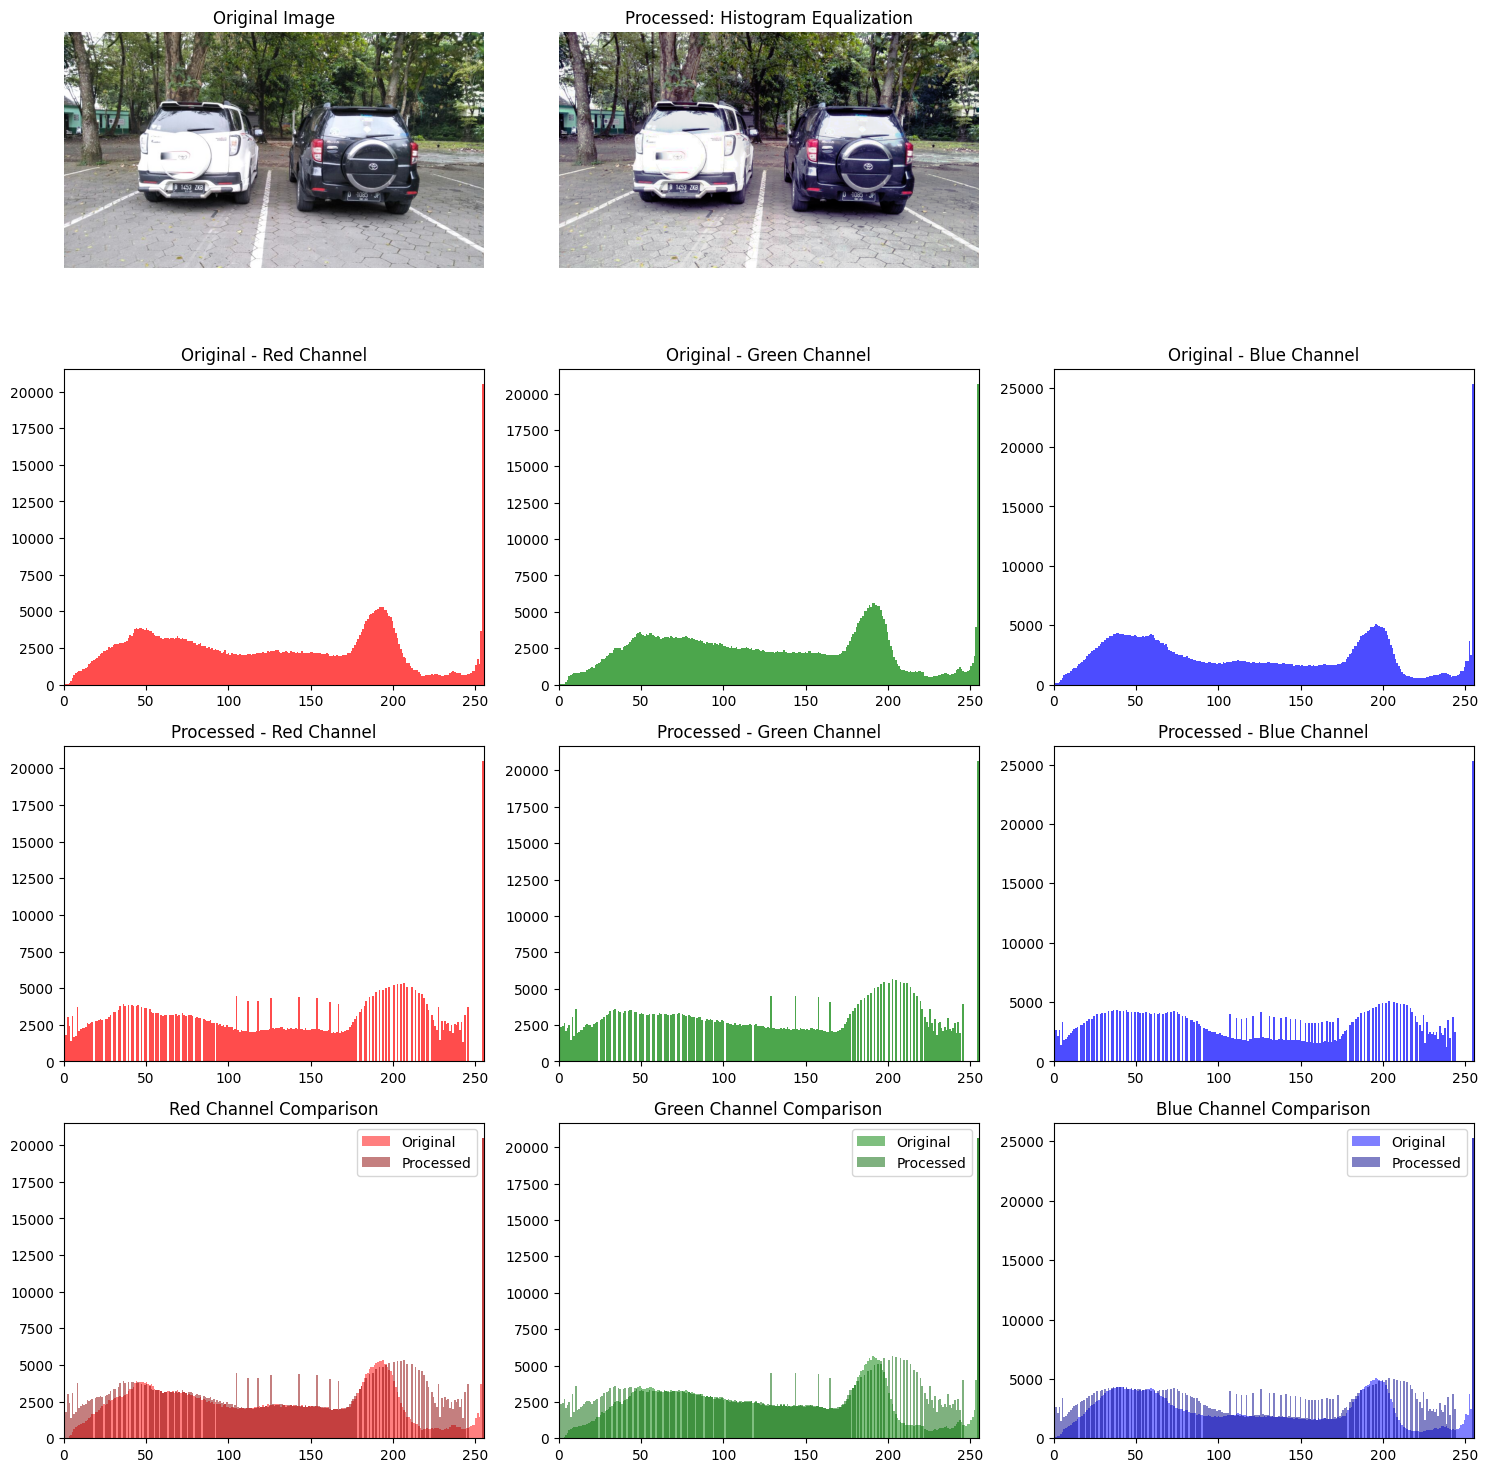

In [15]:
display(image_path, "Histogram Equalization")

Saved figure to output/output2_ipynb/Histogram_Stretching.png


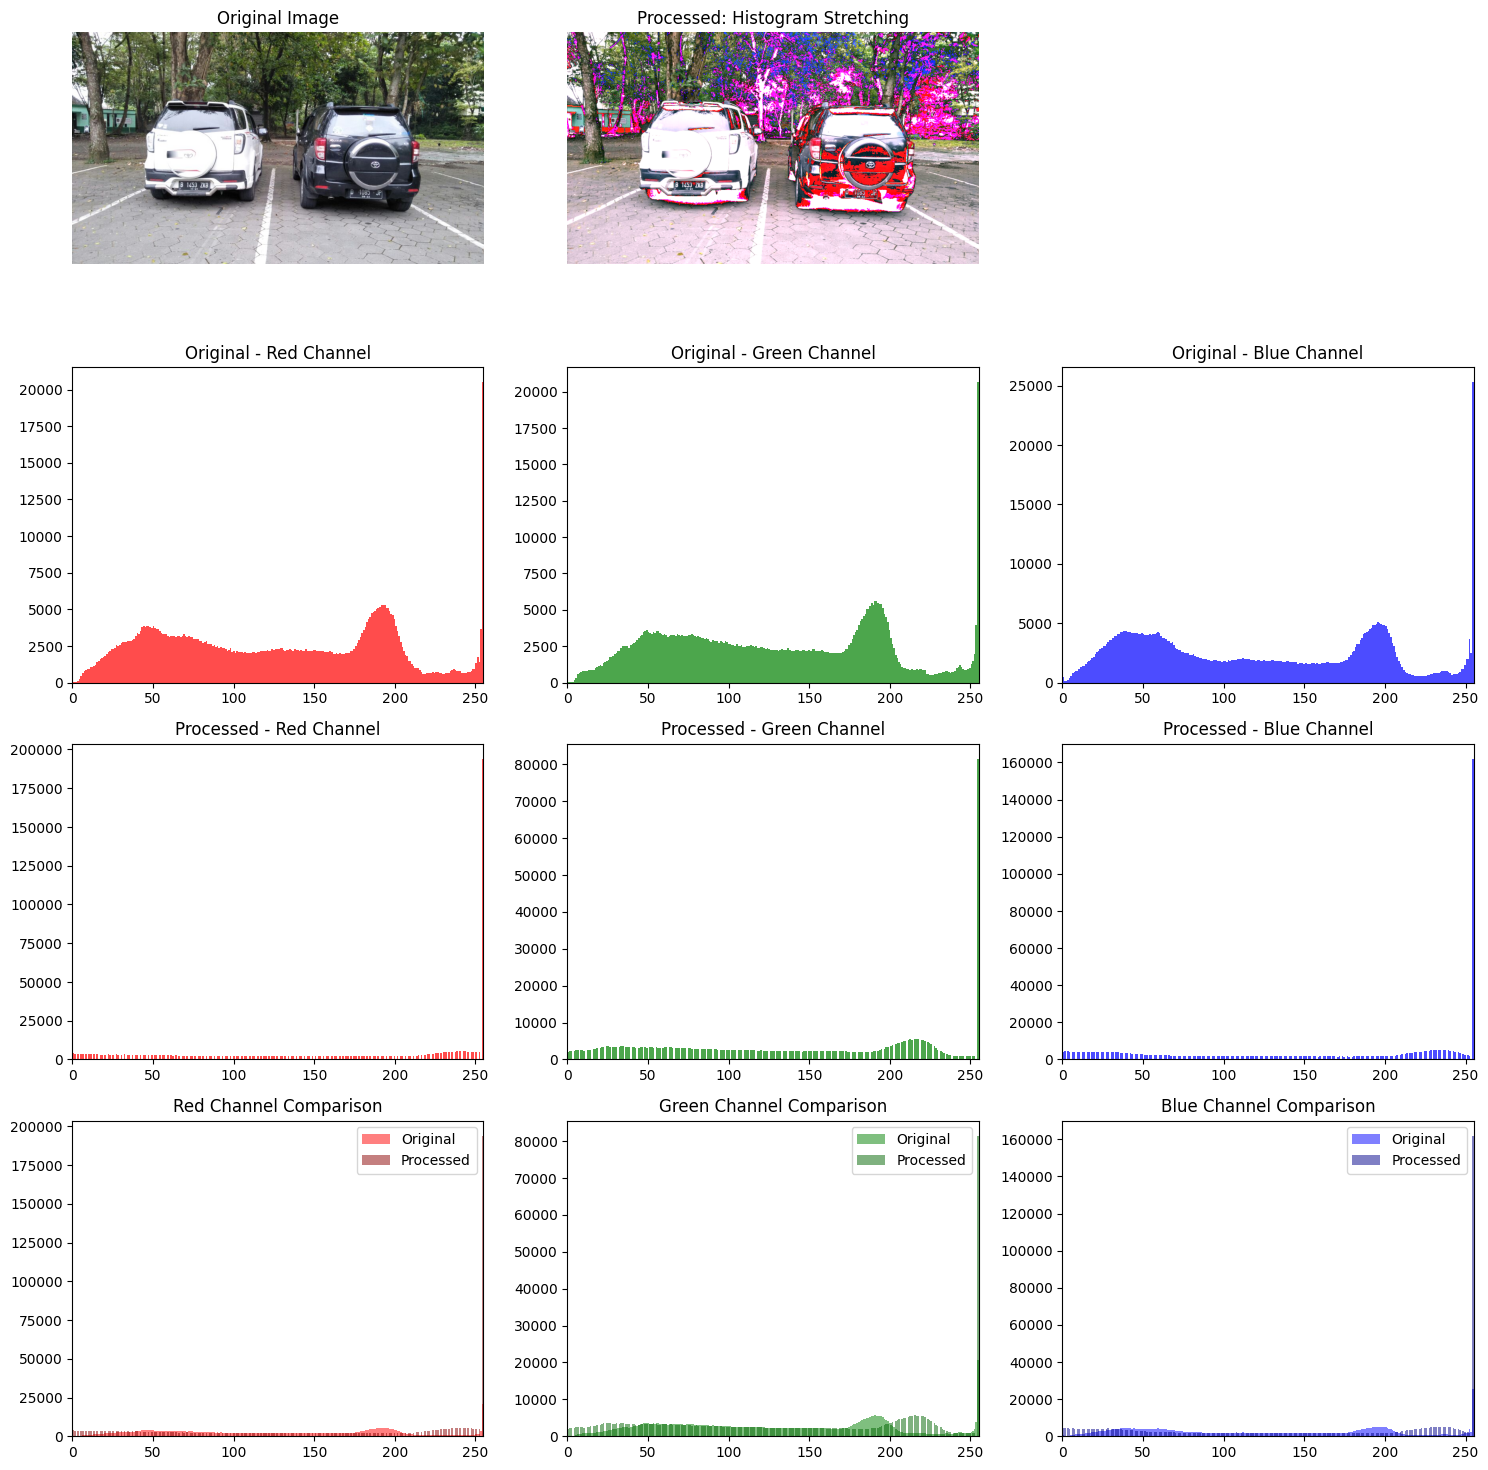

In [16]:
display(image_path, "Histogram Stretching")